# Example: Segment water in GDL to quantify influence of liquid water on electrochemistry

In [1]:
# modules
import os
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import dask
import dask.array
from scipy import ndimage
from skimage import filters, feature, io
from skimage.morphology import disk,ball
import sys
from itertools import combinations_with_replacement
import pickle
import imageio
import json
from dask.distributed import Client, LocalCluster
import subprocess
import gc
import h5py
import logging
import warnings
warnings.filterwarnings('ignore')

from dask import config as cfg

# did not see noticeable effects:
cfg.set({'distributed.scheduler.worker-ttl': None, # Workaround so that dask does not kill workers while they are busy fetching data: https://dask.discourse.group/t/dask-workers-killed-because-of-heartbeat-fail/856, maybe this helps: https://www.youtube.com/watch?v=vF2VItVU5zg?
        'distributed.admin.low-level-log-length': 100 #potential workaround for ballooning scheduler memory https://baumgartner.io/posts/how-to-reduce-memory-usage-of-dask-scheduler/
        })

# get the ML functions, TODO: make a library once it works/is in a stable state
pytrainpath = '/mpc/homes/fische_r/lib/pytrainseg' #path of git repo
cwd = os.getcwd()
os.chdir(pytrainpath)
from filter_functions import image_filter
import training_functions as tfs
from training_functions import train_segmentation
from segmentation import segmentation
pytrain_git_sha = subprocess.check_output(['git', 'rev-parse', '--short', 'HEAD']).decode().strip()
os.chdir(cwd)

#paths
toppath = '/mpc/homes/fische_r/NAS/DASCOELY'
toppathSSD = '/mnt/SSD/fische_r/COELY'
temppath = '/mnt/SSD/fische_r/tmp'
training_path =  '/mnt/SSD/fische_r/COELY/05_water_GDL_ML/'
# memlim = '840GB'
memlim = '440GB' #per worker, sum should be leave some head room, needs experimenting to find right balance, sometimes there is unexplainable memeroy demand by dask

path_04_4D = os.path.join(toppathSSD, '04_lowpass_filtered_4D')
# fetch githash
cwd = os.getcwd()

# provide the path of the pytrainseg repo
gitpath = ''
os.chdir(gitpath)
git_sha = subprocess.check_output(['git', 'rev-parse', '--short', 'HEAD']).decode().strip()
githash = subprocess.check_output(['git', 'rev-parse', 'HEAD']).decode().strip()
os.chdir(cwd)

NameError: name 'gitpath' is not defined

### functionalities for interactive training

In [2]:
from ipywidgets import Image
from ipywidgets import ColorPicker, IntSlider, link, AppLayout, HBox
from ipycanvas import  hold_canvas,  MultiCanvas #RoughCanvas,Canvas,

def on_mouse_down(x, y):
    global drawing
    global position
    global shape
    drawing = True
    position = (x, y)
    shape = [position]

def on_mouse_move(x, y):
    global drawing
    global position
    global shape
    if not drawing:
        return
    with hold_canvas():
        canvas.stroke_line(position[0], position[1], x, y)
        position = (x, y)
    shape.append(position)

def on_mouse_up(x, y):
    global drawing
    global positiondu
    global shape
    drawing = False
    with hold_canvas():
        canvas.stroke_line(position[0], position[1], x, y)
        canvas.fill_polygon(shape)
    shape = []
    
def display_feature(i, TS, feat_stack):
    # print('selected '+TS.feature_names[i])
    im = feat_stack[:,:,i]
    im8 = im-im.min()
    im8 = im8/im8.max()*255
    return im8

### fire up dask, distributed Client currently not usable. No idea how not setting up dask affects the computation

In [3]:
dask.config.config['temporary-directory'] = temppath
def boot_client(dashboard_address=':35000', memory_limit = memlim, n_workers=2):
    tempfolder = temppath  #a big SSD is a major adavantage to allow spill to disk and still be efficient. large dataset might crash with too small SSD or be slow with normal HDD
    
# here you have the option to use a virtual cluster or even slurm on ra (not attempted yet)
    cluster = LocalCluster(dashboard_address=dashboard_address, memory_limit = memory_limit, n_workers=n_workers, silence_logs=logging.ERROR) #settings optimised for mpc2959, play around if needed, if you know nothing else is using RAM then you can almost go to the limit
# # maybe less workers with more threads makes better use of shared memory 
#don't show warnings, too many seem to block execution
    client = Client(cluster) 
    print('Dashboard at '+client.dashboard_link)
    return client, cluster

In [4]:
client, cluster = boot_client()

Dashboard at http://127.0.0.1:35000/status


In [5]:
def reboot_client(client, dashboard_address=':35000', memory_limit = memlim, n_workers=2):
    client.shutdown()
    cluster = LocalCluster(dashboard_address=dashboard_address, memory_limit = memory_limit, n_workers=n_workers, silence_logs=logging.ERROR)
    client = Client(cluster)
    return client

## Data preparation

### let dask load the data
4D data dimesnions should be in the order xyzt, important is that time is the last dimension

In [22]:
filename = '04_'+sample+'_lowpass_filteres_4D.nc'
imagepath = os.path.join(path_04_4D, filename)

In [ ]:
# get size of 4D array, can be achieved also differently
data = xr.open_dataset(imagepath)
shp = data['image_data'].shape #replace 'image_data' of the entry name in the h5py-file containing the 4D-data
data.close()

In [23]:
file = h5py.File(imagepath)


In [24]:
chunk_space = 36 #maybe experiment with this value
chunks = (chunk_space,chunk_space,chunk_space,shp[-1]) #it seems useful to have all timesteps in one chunk
da = dask.array.from_array(file['image_data'], chunks= chunks) #replace 'image_data' of the entry name in the h5py-file containing the 4D-data

In [25]:
da #check the loaded dask array

dask.array<array, shape=(750, 340, 1916, 63), dtype=uint16, chunksize=(36, 36, 36, 63), chunktype=numpy.ndarray>

### get data into image filter class

In [26]:
IF = image_filter(sigmas = [0,1,3,6]) #based on the experience with weka, larger sigmas are useful and should be considered
IF.data = da
shp = da.shape
coords = {'x': np.arange(shp[0]), 'y': np.arange(shp[1]), 'z': np.arange(shp[2]), 'time': np.arange(shp[3])}
IF.original_dataset = xr.Dataset({'tomo': (['x','y','z','time'], da)},
                                 coords = coords
                                )

### prepare features

In [27]:
IF.prepare()

In [28]:
IF.stack_features()

In [30]:
IF.feature_stack #check the outlined feature stack

dask.array<stack, shape=(750, 340, 1916, 63, 103), dtype=float64, chunksize=(36, 36, 36, 63, 1), chunktype=numpy.ndarray>

In [31]:
IF.make_xarray_nc()

## Training

### set up objects

In [33]:
# where to save label data
training_path_sample = os.path.join(training_path, sample)
if not os.path.exists(training_path_sample):
    os.mkdir(training_path_sample)

In [34]:
TS = train_segmentation(training_path=training_path_sample)
TS.client = client
IF.client = client
TS.cluster = cluster
IF.cluster = cluster
TS.memlim = memlim
TS.n_workers = 2

In [35]:
# TS.training_dict_full = {}

In [36]:
TS.import_lazy_feature_data(IF.result, IF.original_dataset)

In [37]:
IF.combined_feature_names = list(IF.feature_names) + list(IF.feature_names_time_independent)

In [38]:
TS.combined_feature_names = IF.combined_feature_names

In [39]:
TS.combined_feature_names #print out all features

['Gaussian_4D_Blur_0.0',
 'Gaussian_4D_Blur_1.0',
 'Gaussian_4D_Blur_3.0',
 'Gaussian_4D_Blur_6.0',
 'Gaussian_4D_Blur_2.0',
 'diff_of_gauss_4D_1.0_0.0',
 'diff_of_gauss_4D_3.0_0.0',
 'diff_of_gauss_4D_6.0_0.0',
 'diff_of_gauss_4D_2.0_0.0',
 'diff_of_gauss_4D_3.0_1.0',
 'diff_of_gauss_4D_6.0_1.0',
 'diff_of_gauss_4D_2.0_1.0',
 'diff_of_gauss_4D_6.0_3.0',
 'diff_of_gauss_4D_2.0_3.0',
 'diff_of_gauss_4D_2.0_6.0',
 'Gradient_sigma_1.0_0',
 'Gradient_sigma_1.0_1',
 'Gradient_sigma_1.0_2',
 'Gradient_sigma_1.0_3',
 'hessian_sigma_1.0_00',
 'hessian_sigma_1.0_01',
 'hessian_sigma_1.0_02',
 'hessian_sigma_1.0_03',
 'hessian_sigma_1.0_11',
 'hessian_sigma_1.0_12',
 'hessian_sigma_1.0_13',
 'hessian_sigma_1.0_22',
 'hessian_sigma_1.0_23',
 'hessian_sigma_1.0_33',
 'Gradient_sigma_3.0_0',
 'Gradient_sigma_3.0_1',
 'Gradient_sigma_3.0_2',
 'Gradient_sigma_3.0_3',
 'hessian_sigma_3.0_00',
 'hessian_sigma_3.0_01',
 'hessian_sigma_3.0_02',
 'hessian_sigma_3.0_03',
 'hessian_sigma_3.0_11',
 'hessian_

### interactive training

#### check for existing training sets

In [40]:
existing_sets = os.listdir(os.path.join(training_path_sample, 'label_images'))
existing_sets.sort()
existing_sets

[]

In [41]:
training_path

'/mpc/homes/fische_r/NAS/DASCOELY/processing/05_water_GDL_ML/'

In [42]:
# you can load a compatible pickled training dict, check feature names
# TS.training_dict = pickle.load(open(os.path.join(TS.training_path, pytrain_git_sha+'_training_dict.p'),'rb'))

In [43]:
TS.training_dict = {}

#### re-train with existing label sets. clear the training dictionary if necessary (training_dict)

In [44]:
# TS.train()

#### import training dict of other samples 
(replace sample name and repeat for multiple samples), if necessary check features for overlap

In [45]:
# oldsample = '4'
# oldgitsha = 'e42ad75' 
# training_dict_old = pickle.load(open(os.path.join(training_path, oldsample,  oldgitsha+'_training_dict.p'),'rb'))
# oldfeatures = pickle.load(open(os.path.join(training_path, oldsample,  oldgitsha+'_feature_names.p'),'rb'))
    
#     # pickle.dump(TS.training_dict, open(os.path.join(TS.training_path, pytrain_git_sha+'_training_dict.p'),'wb'))
# # pickle.dump(TS.feature_names, open(os.path.join(TS.training_path, pytrain_git_sha+'_feature_names.p'),'wb'))

# for key in training_dict_old.keys():
#     TS.training_dict[oldsample+key] = training_dict_old[key]

#### suggest a new training coordinate
currently retraining with new feature stack not properly implemented. Workaround: choose from the exiting training sets and train with them (additional labeling optional)

In [49]:
TS.suggest_training_set() #this function does not work anymoere as intended, run it a few times until it gives a reasonable suggestion

You could try  x = 680  and  feature = 8
However, please sort it like the original xyztimetime_0feature


In [50]:
c1 = 'x'
p1 = 530
c2 = 'time'
p2 = 16

In [111]:
TS.load_training_set(c1, p1, c2, p2)

2023-10-16 16:35:37,076 - distributed.nanny - WARNING - Restarting worker
2023-10-16 16:35:37,084 - distributed.nanny - WARNING - Restarting worker


In [115]:
if not len(client.cluster.workers)>1:   
    client = reboot_client(client)
    TS.client = client
    IF.client = client

In [116]:
im8 = TS.current_im8

In [117]:
im8.shape

(340, 1916)

In [118]:
# TS.get_slice_feat_stack()

In [119]:
feat_data = TS.feat_data
[c1,p1,c2,p2] = TS.current_coordinates
newslice = True

if c1 == 'x' and c2 == 'time':
    feat_stack = feat_data['feature_stack'].sel(x = p1, time = p2)
    feat_stack_t_idp = feat_data['feature_stack_time_independent'].sel(x = p1, time_0 = 0)
elif c1 == 'x' and c2 == 'y':
    feat_stack = feat_data['feature_stack'].sel(x = p1, y = p2)#.data
    feat_stack_t_idp = feat_data['feature_stack_time_independent'].sel(x = p1, y = p2)
elif c1 == 'x' and c2 == 'z':
    feat_stack = feat_data['feature_stack'].sel(x = p1, z = p2)#.data
    feat_stack_t_idp = feat_data['feature_stack_time_independent'].sel(x = p1, z = p2)
elif c1 == 'y' and c2 == 'z':
    feat_stack = feat_data['feature_stack'].sel(y = p1, z = p2)#.data
    feat_stack_t_idp = feat_data['feature_stack_time_independent'].sel(y = p1, z = p2)
elif c1 == 'y' and c2 == 'time':
    feat_stack = feat_data['feature_stack'].sel(y = p1, time = p2)#.data
    feat_stack_t_idp = feat_data['feature_stack_time_independent'].sel(y = p1, time_0 = 0)
elif c1 == 'z' and c2 == 'time':
    feat_stack = feat_data['feature_stack'].sel(z = p1, time = p2)#.data
    feat_stack_t_idp = feat_data['feature_stack_time_independent'].sel(z = p1, time_0 = 0)

In [120]:
if type(feat_stack) is not np.ndarray:
        fut = client.scatter(feat_stack)
        fut = fut.result()
        fut = fut.compute()
        feat_stack = fut
        try:
            client.restart()
        except:
            client = reboot_client(client)
            TS.client = client
            IF.client = client   

/mpc/homes/fische_r/miniconda3/lib/python3.11/site-packages/distributed/client.py:3149: UserWarning: Sending large graph of size 70.32 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2023-10-16 16:48:40,746 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2023-10-16 16:48:43,874 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
2023-10-16 16:48:45,807 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
2023-10-16 16:48:48,566 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2023-10-16 16:48:52,023 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2023-10-16 16:48:54,870 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time r

#### calculate feature stack and reboot cluster if workers do not return
client restart seemingly appears to appear unexplainable memory leak

In [ ]:
if type(feat_stack_t_idp) is not np.ndarray:
        fut = client.scatter(feat_stack_t_idp)
        fut = fut.result()
        fut = fut.compute()
        feat_stack_t_idp = fut
        try:
            client.restart()
        except:
            client = reboot_client(client)
            TS.client = client
            IF.client = client   
    

In [ ]:
feat_stack = np.concatenate([feat_stack, feat_stack_t_idp], axis = 2)

In [ ]:
TS.current_feat_stack = feat_stack
if type(TS.current_feat_stack) is not np.ndarray:
    TS.current_computed = False
else:
    TS.current_computed = True

#### canvas for labeling

In [ ]:
# imm = mean[:,p1,:].copy()
# im8m= imm-imm.min()
# im8m = im8m/im8m.max()*255
# im8 = im8m

In [ ]:
# give a list of features with indices, you can display any feature to help labeling
for i in range(len(IF.combined_feature_names)):
    print(i, IF.combined_feature_names[i])

In [ ]:
# double check index
i  = 74
print(i, IF.combined_feature_names[i])

### label the training image by setting the color and drawing on the canvas
- currently 4 options possible: #ff0000, #00ff00, #0000ff, #ffff00
- rerun cell to clear labeling
- tip: use the trackpad (panning?) zoom instead of ctrl+scrollwheel

In [178]:
alpha = 0.35
# zoom1 = (-500,-1)
# zoom2 = (600,1400)

# zoom1 = (0, -1)
# zoom2 = (0, -1)

# im8 = TS.current_im8
#trick: use gaussian_time_4_0 to label static phases ()
# im8 = display_feature(104, TS, feat_stack)
# im8 = display_feature(0, TS)
# print(IF.combined_feature_names[-20])
print('original shape: ',im8.shape)
im8_display = im8.copy() #[zoom1[0]:zoom1[1], zoom2[0]:zoom2[1]]
# print('diyplay shape : ',im8_display.shape,' at: ', (zoom1[0], zoom2[0]))

resultim = TS.current_result.copy()

resultim_display = resultim #[zoom1[0]:zoom1[1], zoom2[0]:zoom2[1]]


width = im8_display.shape[1]
height = im8_display.shape[0]
Mcanvas = MultiCanvas(4, width=width, height=height)
background = Mcanvas[0]
resultdisplay = Mcanvas[2]
truthdisplay = Mcanvas[1]
canvas = Mcanvas[3]
canvas.sync_image_data = True
drawing = False
position = None
shape = []
image_data = np.stack((im8_display, im8_display, im8_display), axis=2)
background.put_image_data(image_data, 0, 0)
slidealpha = IntSlider(description="Result overlay", value=0.15)
resultdisplay.global_alpha = alpha #slidealpha.value
if np.any(resultim>0):
    result_data = np.stack(((resultim_display==0), (resultim_display==1),(resultim_display==2)), axis=2)*255
    mask3 = resultim_display==3
    result_data[mask3,0] = 255
    result_data[mask3,1] = 255
else:
    result_data = np.stack((0*resultim, 0*resultim, 0*resultim), axis=2)
resultdisplay.put_image_data(result_data, 0, 0)
canvas.on_mouse_down(on_mouse_down)
canvas.on_mouse_move(on_mouse_move)
canvas.on_mouse_up(on_mouse_up)
picker = ColorPicker(description="Color:", value="#ff0000") #red
# picker = ColorPicker(description="Color:", value="#0000ff") #blue
# picker = ColorPicker(description="Color:", value="#00ff00") #green

link((picker, "value"), (canvas, "stroke_style"))
link((picker, "value"), (canvas, "fill_style"))
link((slidealpha, "value"), (resultdisplay, "global_alpha"))

HBox((Mcanvas,picker))
# HBox((Mcanvas,)) #picker 

original shape:  (340, 1916)


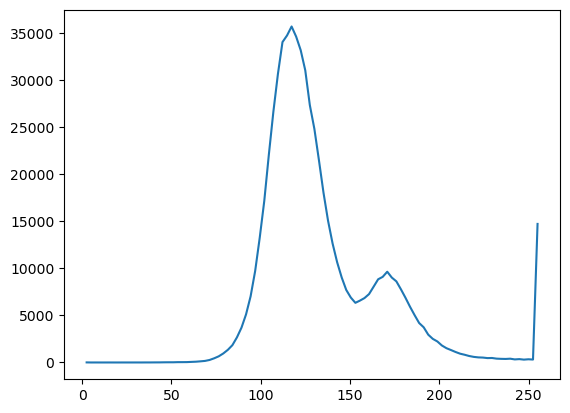

In [170]:
# comment/uncomment to adjust brightness/contrast of displayed image
tfs.plot_im_histogram(im8)
# im8 = TS.current_im8
# im8 = tfs.adjust_image_contrast(im8,30,110)

#### inspect labels and training progress

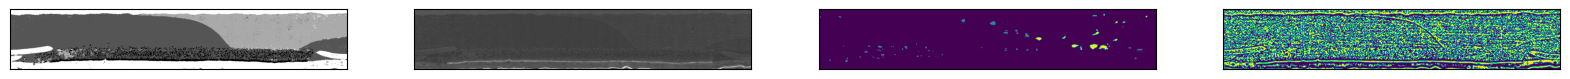

In [171]:
fig, axes = plt.subplots(1,4, figsize=(20,10))
axes[0].imshow(TS.current_result, 'gray')
axes[1].imshow(TS.current_im8, 'gray')

axes[2].imshow(TS.current_truth)
if TS.current_computed:
    axes[3].imshow(TS.current_feat_stack[:,:,-10])
else:
    axes[3].imshow(TS.current_result, 'gray')

for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])

#### update training set if labels are ok

In [172]:
label_set = canvas.get_image_data()

test = TS.current_truth.copy()

test[np.bitwise_and(label_set[:,:,0]>0,np.bitwise_xor(label_set[:,:,0]>0,label_set[:,:,1]>0))] = 1
test[label_set[:,:,1]>0] = 2
test[label_set[:,:,2]>0] = 4 #order of 4&3 flipped for legacy reasons (existing training labels)
test[np.bitwise_and(label_set[:,:,0]>0,label_set[:,:,1]>0)] = 3

TS.current_truth = test.copy()
imageio.imsave(TS.current_truthpath, TS.current_truth)

#### train!

In [175]:
TS.train_slice()

training and classifying


#### iterate labeling and training on current training slice until happy then repeat on different slice

#### check on training progress by plausible feature importance

Text(0, 0.5, 'importance')

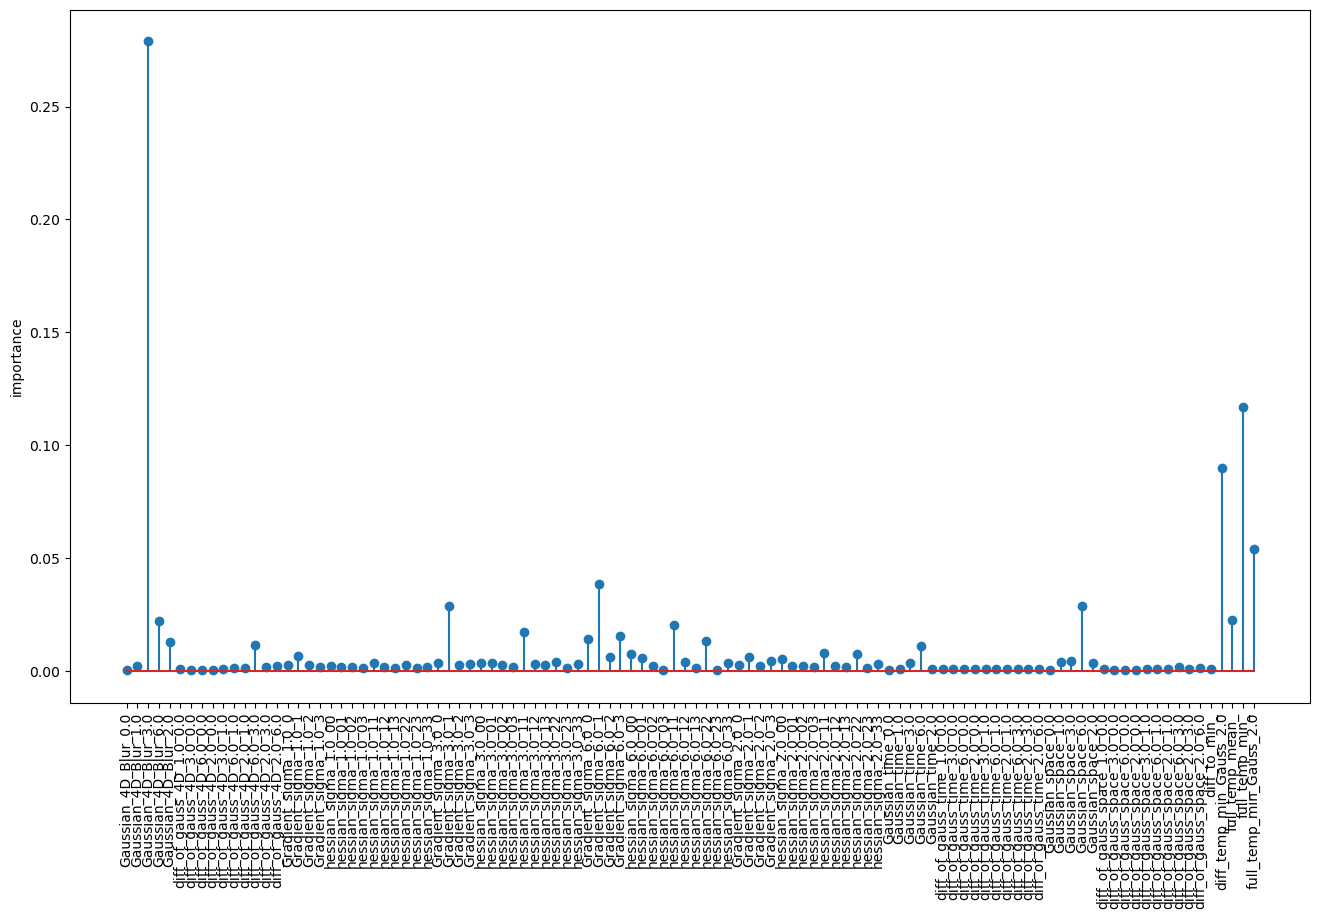

In [180]:
plt.figure(figsize=(16,9))
plt.stem(IF.combined_feature_names, TS.clf.feature_importances_,'x')
plt.xticks(rotation=90)
plt.ylabel('importance') 
# plt.xticks(rotation = 60)
# plt.yscale('log')

### when done, maybe save the classifier and optional the training dict (avoids recalculating the training sets, but might be large)

In [181]:
TS.pickle_classifier()
pickle.dump(TS.training_dict, open(os.path.join(TS.training_path, pytrain_git_sha+'_training_dict.p'),'wb'))
pickle.dump(TS.combined_feature_names, open(os.path.join(TS.training_path, pytrain_git_sha+'_feature_names.p'),'wb'))

In [182]:
TS.training_path

'/mpc/homes/fische_r/NAS/DASCOELY/processing/05_water_GDL_ML/4'

In [183]:
pytrain_git_sha

'e42ad75'

## Segmentation of full data set
Sometimes the dask esxecution stops randomly. Cancel notebook, save intermediate results and restart the notebook to continue

In [40]:
from segmentation import segmentation

In [41]:
classifier_path=os.path.join(training_path, 'classifier.p')
SM = segmentation(training_path = training_path, classifier_path=classifier_path)

In [42]:
SM.clf = pickle.load(open(os.path.join(training_path, 'classifier.p'), 'rb')) 

In [43]:
clf = SM.clf
clf.n_jobs = 64 #threads to be used for classifier. more is faster but needs more RAM

### merge time-independent features

In [47]:
# dask.array.stack([TS.feat_data['feature_stack_time_independent'][:,:,:,0,:]]*da.shape[-1], axis=-2)
feat_idp = TS.feat_data['feature_stack_time_independent'][:,:,:,0,:]

In [49]:
# feat = dask.array.concatenate([TS.feat_data['feature_stack'], test], axis=-1)
feat = TS.feat_data['feature_stack']

In [51]:
feat #check 

<xarray.DataArray 'feature_stack' (x: 750, y: 340, z: 1916, time: 63,
                                   feature: 103)>
dask.array<stack, shape=(750, 340, 1916, 63, 103), dtype=float64, chunksize=(36, 36, 36, 63, 1), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) int64 0 1 2 3 4 5 6 7 8 ... 741 742 743 744 745 746 747 748 749
  * y        (y) int64 0 1 2 3 4 5 6 7 8 ... 331 332 333 334 335 336 337 338 339
  * z        (z) int64 0 1 2 3 4 5 6 7 ... 1909 1910 1911 1912 1913 1914 1915
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9 ... 53 54 55 56 57 58 59 60 61 62
  * feature  (feature) <U27 'Gaussian_4D_Blur_0.0' ... 'diff_temp_min_Gauss_2.0'

### check aligment of chunks and select suitable "super-chunk" shape to split calculation in parts, example below
superchunk has unfortunately and apparently to fit twice into RAM, no idea what's going there

In [52]:
750*2.6

1950.0

In [53]:
350/50

7.0

In [54]:
# check length of loops to process entire dataset, estimate size of obtained sub-feature to avoid out-of-memory issues
i = 14
j = i
# j = 3
dim1 = 54#better use multiple of chunk size !?
dim2 = int(2.6*dim1)
feat[i*dim1:(i+1)*dim1,:,j*dim2:(j+1)*dim2,:,:] #select all features and all time steps, but you are free in space; als large as possible and as small as necessary. limit is the available RAM to collect the dask result

<xarray.DataArray 'feature_stack' (x: 0, y: 340, z: 0, time: 63, feature: 103)>
dask.array<getitem, shape=(0, 340, 0, 63, 103), dtype=float64, chunksize=(0, 36, 0, 63, 1), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) int64 
  * y        (y) int64 0 1 2 3 4 5 6 7 8 ... 331 332 333 334 335 336 337 338 339
  * z        (z) int64 
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9 ... 53 54 55 56 57 58 59 60 61 62
  * feature  (feature) <U27 'Gaussian_4D_Blur_0.0' ... 'diff_temp_min_Gauss_2.0'

In [55]:
segs = np.zeros(feat.shape[:4], dtype=np.uint8)
# segs = pickle.load(open(os.path.join(temppath,'segs.p')), 'rb'))  #segmentation will most likely crash a few times so re-lead reached state

In [57]:
# maybe helps reducing memory leak issues, but not sure if it actually does anything ...
client.run(gc.collect)
gc.collect()

50

In [58]:
import ctypes #same as above
def trim_memory() -> int:
    libc = ctypes.CDLL("libc.so.6")
    return libc.malloc_trim(0)

In [59]:
trim_memory()

1

In [ ]:
limit = 14
# TODO: Workaround: write intermediates to disk and restart dask client/scheduler/workers to get rid of unmanaged memory
# possible solution: do data handling on mpc2053 and calculations on mpc2959 -> leaves some RAM --> gc.collect() not necessary anymore
# appearantly starts to become critical after 12 iteratons
# from i=7, j=10 already done
# TODO write i and j to file to track progress even when closing jupyter
for i in range(4,limit):
    # pickle.dump(segs, open(os.path.join(training_path,'segs_temp.p'), 'wb'))
    
    print(str(i+1)+'/'+str(limit))

    start = 0
    if i == 4:
        start = 7
    for j in range(start,limit):
        gc.collect() 
        client.run(gc.collect)
        client.run(trim_memory)
        trim_memory()
        print(j)
        #with joblib.parallel_backend('dask'):
        # part = feat[i*dim1:(i+1)*dim1,:,j*dim2:(j+1)*dim2,:,:] #.persist() #compute() may blow up the memory ?! https://stackoverflow.com/questions/73770527/dask-compute-uses-twice-the-expected-memory

        part = feat[i*dim1:(i+1)*dim1,:,j*dim2:(j+1)*dim2,:,:] 
        part_idp = feat_idp[i*dim1:(i+1)*dim1,:,j*dim2:(j+1)*dim2,:]      
        if 0 in part.shape:
            print('hit the edge (one dimension 0), ignore')
            continue

        

        if type(part) is not np.ndarray:
            fut = client.scatter(part)
            fut = fut.result()
            fut = fut.compute()
            part = fut
            try:
                client.restart()
            except:
                client = reboot_client(client)
                
        # if j == 0: print('now the time independent part')
        if type(part_idp) is not np.ndarray:
            fut = client.scatter(part_idp)
            fut = fut.result()
            fut = fut.compute()
            part_idp = fut
            try:
                client.restart()
            except:
                client = reboot_client(client)

        # feat = dask.array.concatenate([TS.feat_data['feature_stack'], test], axis=-1)
        # dask.array.stack([TS.feat_data['feature_stack_time_independent'][:,:,:,0,:]]*da.shape[-1], axis=-2)
        part_idp = np.stack([part_idp]*da.shape[-1], axis=-2)
        part = np.concatenate([part, part_idp], axis = -1)
        del part_idp
            
        # part = part.compute()

        shp = part.shape
        num_feat = part.shape[-1]  
        part = part.reshape(-1,num_feat)

        psplit = int(part.shape[0]/2)

        # print('create part 1')
        part1 = part[:psplit,:]
        # print('create part 2')
        part2 = part[psplit:,:]
        # print('segmenting 1')

        # with joblib.parallel_backend('dask'):
        seg1 = clf.predict(part1).astype(np.uint8)
        del part1
        # print('segmenting 2')
        # with joblib.parallel_backend('dask'):
        seg2 = clf.predict(part2).astype(np.uint8)
        # print('wrap results')
        del part2
        del part
        # gc.collect()

        seg = np.concatenate([seg1,seg2])
        print(seg.shape)
        del seg1
        del seg2

          #this step needs a lot of RAM ?! appearantly not

        # plt.dump(seg, open(os.path.join(training_path,'seg_'+str(i)+'_'+str(j)+'.p'), 'wb'))


        # put segs together when all calculated
        seg = seg.reshape(shp[:4])
    # not sure if this switch cases are necessary
        if i < limit-1 and j < limit-1:
            segs[i*dim1:(i+1)*dim1,:,j*dim2:(j+1)*dim2,:] = seg
        elif not i < limit-1 and j < limit-1:
            segs[i*dim1:,:,j*dim2:(j+1)*dim2,:] =  seg
        elif not j < limit-1 and i < limit-1:
            segs[i*dim1:(i+1)*dim1,:,j*dim2:,:] =  seg
        else:
            segs[i*dim1:,:,j*dim2:,:] = seg
            
        del seg

5/14
7


/mpc/homes/fische_r/miniconda3/lib/python3.11/site-packages/distributed/client.py:3149: UserWarning: Sending large graph of size 12.53 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2023-11-06 08:55:05,396 - distributed.nanny - WARNING - Restarting worker
2023-11-06 08:55:11,790 - distributed.nanny - WARNING - Restarting worker
2023-11-06 09:00:09,419 - distributed.nanny - WARNING - Restarting worker
2023-11-06 09:00:10,414 - distributed.nanny - WARNING - Restarting worker


(161935200,)
8


/mpc/homes/fische_r/miniconda3/lib/python3.11/site-packages/distributed/client.py:3149: UserWarning: Sending large graph of size 10.41 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2023-11-06 09:17:54,795 - distributed.nanny - WARNING - Restarting worker
2023-11-06 09:18:01,541 - distributed.nanny - WARNING - Restarting worker
2023-11-06 09:22:40,612 - distributed.nanny - WARNING - Restarting worker
2023-11-06 09:22:41,556 - distributed.nanny - WARNING - Restarting worker


(161935200,)
9


2023-11-06 09:35:24,797 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
2023-11-06 09:35:37,336 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
2023-11-06 09:35:53,042 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-11-06 09:36:15,587 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
/mpc/homes/fische_r/miniconda3/lib/python3.11/site-packages/distributed/client.py:3149: UserWarning: Sending large graph of size 10.41 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2023-11-06 09:40:50,631 - distributed.nanny - WARNING - Restarting worker
2023-11-06 09:40:57,532 - distributed.nanny - WARNING - Restarting worker
2023-11-06 09:45:39,235 - distributed.nanny - WARNING - Restarting worker
2023-11-06 09

(161935200,)


2023-11-06 09:52:34,605 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


10


2023-11-06 09:57:30,109 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2023-11-06 09:57:44,375 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2023-11-06 09:57:51,901 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2023-11-06 09:58:01,737 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
2023-11-06 09:58:14,450 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
2023-11-06 09:58:30,600 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
2023-11-06 09:58:53,584 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
/mpc/homes/fische_r/miniconda3/lib/python3.11/site-packages/distributed/client.py:3149: Us

(161935200,)


2023-11-06 10:16:32,179 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


11


2023-11-06 10:21:25,774 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
2023-11-06 10:21:41,001 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
2023-11-06 10:21:48,413 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
2023-11-06 10:21:58,320 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
2023-11-06 10:22:11,508 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2023-11-06 10:22:27,356 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2023-11-06 10:22:50,498 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
/mpc/homes/fische_r/miniconda3/lib/python3.11/site-packages/distributed/client.py:3149: Us

(161935200,)


2023-11-06 10:40:31,128 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


12


2023-11-06 10:45:21,833 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
2023-11-06 10:45:36,824 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
2023-11-06 10:45:44,516 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
2023-11-06 10:45:54,646 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2023-11-06 10:46:07,675 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2023-11-06 10:46:23,604 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2023-11-06 10:46:46,848 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
/mpc/homes/fische_r/miniconda3/lib/python3.11/site-packages/distributed/client.py:3149: Us

(161935200,)


2023-11-06 11:04:38,909 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


13


2023-11-06 11:09:29,488 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-11-06 11:09:44,479 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-11-06 11:09:52,132 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-11-06 11:10:02,367 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-11-06 11:10:15,430 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-11-06 11:10:31,395 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-11-06 11:10:54,757 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-11-06 11:12:19,552 - distributed.utils_perf - WARNING - full garbage collections took

(111041280,)
6/14


2023-11-06 11:23:51,742 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


0


2023-11-06 11:28:49,177 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-11-06 11:29:04,508 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-11-06 11:29:12,164 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-11-06 11:29:22,661 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-11-06 11:29:35,824 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-11-06 11:29:52,164 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-11-06 11:30:16,610 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-11-06 11:34:32,664 - distributed.nanny - WARNING - Restarting worker
2023-11-06 11:34

(161935200,)


2023-11-06 11:46:05,926 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


1


2023-11-06 11:51:04,631 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-11-06 11:51:20,234 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-11-06 11:51:28,624 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-11-06 11:51:39,127 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-11-06 11:51:52,647 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-11-06 11:52:09,457 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-11-06 11:52:35,209 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
/mpc/homes/fische_r/miniconda3/lib/python3.11/site-packages/distributed/client.py:3149: Us

(161935200,)


2023-11-06 12:09:08,272 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


2


2023-11-06 12:14:05,789 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-11-06 12:14:21,448 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-11-06 12:14:29,838 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-11-06 12:14:40,359 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-11-06 12:14:53,881 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-11-06 12:15:10,645 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-11-06 12:15:36,436 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
/mpc/homes/fische_r/miniconda3/lib/python3.11/site-packages/distributed/client.py:3149: Us

(161935200,)


2023-11-06 12:32:07,763 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


3


/mpc/homes/fische_r/miniconda3/lib/python3.11/site-packages/distributed/client.py:3149: UserWarning: Sending large graph of size 12.54 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2023-11-06 12:43:37,152 - distributed.nanny - WARNING - Restarting worker
2023-11-06 12:43:43,362 - distributed.nanny - WARNING - Restarting worker
2023-11-06 12:48:25,187 - distributed.nanny - WARNING - Restarting worker
2023-11-06 12:48:26,174 - distributed.nanny - WARNING - Restarting worker


(161935200,)
4


/mpc/homes/fische_r/miniconda3/lib/python3.11/site-packages/distributed/client.py:3149: UserWarning: Sending large graph of size 12.54 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2023-11-06 13:06:53,039 - distributed.nanny - WARNING - Restarting worker
2023-11-06 13:06:59,293 - distributed.nanny - WARNING - Restarting worker
2023-11-06 13:11:42,160 - distributed.nanny - WARNING - Restarting worker
2023-11-06 13:11:43,184 - distributed.nanny - WARNING - Restarting worker


(161935200,)
5


/mpc/homes/fische_r/miniconda3/lib/python3.11/site-packages/distributed/client.py:3149: UserWarning: Sending large graph of size 12.54 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2023-11-06 13:29:37,626 - distributed.nanny - WARNING - Restarting worker
2023-11-06 13:29:44,513 - distributed.nanny - WARNING - Restarting worker
2023-11-06 13:34:26,730 - distributed.nanny - WARNING - Restarting worker
2023-11-06 13:34:27,716 - distributed.nanny - WARNING - Restarting worker


(161935200,)
6


/mpc/homes/fische_r/miniconda3/lib/python3.11/site-packages/distributed/client.py:3149: UserWarning: Sending large graph of size 12.54 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2023-11-06 13:52:41,781 - distributed.nanny - WARNING - Restarting worker
2023-11-06 13:52:47,984 - distributed.nanny - WARNING - Restarting worker
2023-11-06 13:57:29,691 - distributed.nanny - WARNING - Restarting worker
2023-11-06 13:57:30,680 - distributed.nanny - WARNING - Restarting worker


(161935200,)
7


/mpc/homes/fische_r/miniconda3/lib/python3.11/site-packages/distributed/client.py:3149: UserWarning: Sending large graph of size 12.54 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2023-11-06 14:15:53,186 - distributed.nanny - WARNING - Restarting worker
2023-11-06 14:15:59,358 - distributed.nanny - WARNING - Restarting worker
2023-11-06 14:20:43,287 - distributed.nanny - WARNING - Restarting worker
2023-11-06 14:20:44,273 - distributed.nanny - WARNING - Restarting worker


(161935200,)
8


/mpc/homes/fische_r/miniconda3/lib/python3.11/site-packages/distributed/client.py:3149: UserWarning: Sending large graph of size 10.42 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2023-11-06 14:38:47,636 - distributed.nanny - WARNING - Restarting worker
2023-11-06 14:38:53,826 - distributed.nanny - WARNING - Restarting worker
2023-11-06 14:43:36,553 - distributed.nanny - WARNING - Restarting worker
2023-11-06 14:43:37,502 - distributed.nanny - WARNING - Restarting worker


(161935200,)
9


/mpc/homes/fische_r/miniconda3/lib/python3.11/site-packages/distributed/client.py:3149: UserWarning: Sending large graph of size 10.42 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2023-11-06 15:01:50,088 - distributed.nanny - WARNING - Restarting worker
2023-11-06 15:01:56,220 - distributed.nanny - WARNING - Restarting worker
2023-11-06 15:06:46,574 - distributed.nanny - WARNING - Restarting worker
2023-11-06 15:06:47,510 - distributed.nanny - WARNING - Restarting worker


(161935200,)
10


/mpc/homes/fische_r/miniconda3/lib/python3.11/site-packages/distributed/client.py:3149: UserWarning: Sending large graph of size 12.54 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2023-11-06 15:24:58,452 - distributed.nanny - WARNING - Restarting worker
2023-11-06 15:25:05,685 - distributed.nanny - WARNING - Restarting worker
2023-11-06 15:29:46,644 - distributed.nanny - WARNING - Restarting worker
2023-11-06 15:29:47,627 - distributed.nanny - WARNING - Restarting worker


(161935200,)
11


/mpc/homes/fische_r/miniconda3/lib/python3.11/site-packages/distributed/client.py:3149: UserWarning: Sending large graph of size 12.54 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2023-11-06 15:48:13,771 - distributed.nanny - WARNING - Restarting worker
2023-11-06 15:48:20,001 - distributed.nanny - WARNING - Restarting worker


In [67]:
i #check, how far you have got, replace iterators accordingly in the loop above

4

In [68]:
j

7

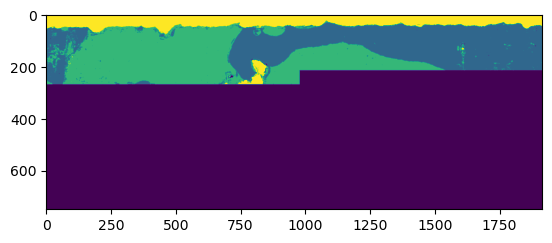

In [69]:
plt.imshow(segs[:,50,:, 20]) #check how it is going

#### dump intermediate result to be picked up and restart kernel 

if something stops working, dump the already segmented volume and restart the kernel with a clean sheet, several things can happen:

- dask image proccesing stops processing (check dashboard): safe to cancel kernel, dump intermediate result, adapt loop and restart kernel (execute all cells except the training from the top)
- something crashed, but the kernel is still alive: dump intermediate result, adapt loop and restart kernel
- kernel died: unfortunately recen progress is gone, restart kernel

Sometime, it also helps to kill the entire jupyter session. There are apparently some weird memory leaks that would be nice to be avoided. Also, a lot of time is spent fetching the calculated feature stack, image processing and classifying does not take very long

In [ ]:
pickle.dump(segs, open(os.path.join(temppath,'segs.p'), 'wb'))

### save result to disk when full volume has been processed

In [67]:
# TODO: include metadata in segmented nc

shp = segs.shape
segdata = xr.Dataset({'segmented': (['x','y','z','timestep'], segs),
                     't_utc': ('timestep', t_utc),
                     'time': ('timestep', time)},
                               coords = {'x': np.arange(shp[0]),
                               'y': np.arange(shp[1]),
                               'z': np.arange(shp[2]),
                               'timestep': np.arange(shp[3]),
                               'feature': TS.combined_feature_names}
                     )
segdata.attrs = data.attrs.copy()
segdata.attrs['05_ML_cropping'] = [a,b,c,d,e,f]
segdata.attrs['pytrain_git'] = pytrain_git_sha
segdata.attrs['05_coely_gitsha'] = git_sha
segdata.attrs['GDL_crop'] = GDL_crop

In [68]:
segpath = os.path.join(training_path_sample, sample+'water_segmentation.nc')

In [69]:
segdata.to_netcdf(segpath)